# Azure Databricks Assessment 2

# Ride-Hailing Trips + Drivers (inline)

# Setup

In [1]:
# Install dependencies (only needed in Google Colab)
# In Azure Databricks, skip this cell
!pip install pyspark==3.5.1 delta-spark==3.1.0
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

In [6]:
# using DELTA in colab
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DataRideHailing") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")

Spark and Delta Lake are ready!


In [7]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import types as T
from datetime import datetime

In [8]:
# ---------- Inline data ----------
# ---------- Schemas ----------
trip_schema = T.StructType([
    T.StructField("trip_id", T.IntegerType()),
    T.StructField("rider_id", T.StringType()),
    T.StructField("driver_id", T.StringType()),
    T.StructField("city", T.StringType()),
    T.StructField("distance_km", T.DoubleType()),
    T.StructField("fare", T.DoubleType()),
    T.StructField("tip", T.DoubleType()),
    T.StructField("ts", T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id", T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating", T.DoubleType()),
    T.StructField("vehicle", T.StringType())
])

In [9]:
# ---------- Data ----------
trips_rows = [
    (1001,"R001","D010","Bengaluru", 12.4, 320.0, 20.0, datetime(2025,8,8,8,5,0)),
    (1002,"R002","D011","Hyderabad", 6.2, 150.0, 10.0, datetime(2025,8,8,8,15,0)),
    (1003,"R003","D012","Pune", 3.5, 90.0, 0.0, datetime(2025,8,8,8,20,0)),
    (1004,"R001","D010","Bengaluru", 18.9, 480.0, 25.0, datetime(2025,8,8,8,45,0)),
    (1005,"R004","D013","Chennai", 10.0, 260.0, 15.0, datetime(2025,8,8,9,5,0)),
    (1006,"R005","D012","Pune", 2.2, 70.0, 0.0, datetime(2025,8,8,9,10,0)),
]

drivers_rows = [
    ("D010","Anil", 4.8,"WagonR"),
    ("D011","Sana", 4.6,"i20"),
    ("D012","Rakesh", 4.4,"Swift"),
    ("D013","Meera", 4.9,"Ciaz")
]

In [10]:
# Create DataFrames
trips_df = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

In [11]:
# ---------- Save as Delta ----------
BASE = "/tmp/delta/ride_hailing"
TRIPS_PATH = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Seeded:")
print(" Trips ->", TRIPS_PATH)
print(" Drivers ->", DRIVERS_PATH)

Seeded:
 Trips -> /tmp/delta/ride_hailing/trips
 Drivers -> /tmp/delta/ride_hailing/drivers


In [14]:
# Show drivers and trips tables
drivers_df.show()
trips_df.show()

+---------+-----------+------+-------+
|driver_id|driver_name|rating|vehicle|
+---------+-----------+------+-------+
|     D010|       Anil|   4.8| WagonR|
|     D011|       Sana|   4.6|    i20|
|     D012|     Rakesh|   4.4|  Swift|
|     D013|      Meera|   4.9|   Ciaz|
+---------+-----------+------+-------+

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|   

# Exercises

# 1) Managed vs Unmanaged Tables
    Create a managed Delta table trips_managed by AS SELECT from the Delta path.
    Create an external (unmanaged) table drivers_ext that points to DRIVERS_PATH .
    Verify locations with DESCRIBE DETAIL and explain the difference in your own
    words.

In [15]:
# Create a managed Delta table trips_managed by AS SELECT from the Delta path.
spark.sql(f"DROP TABLE IF EXISTS trips_managed")

spark.sql(f"""
CREATE TABLE trips_managed
USING DELTA
AS SELECT * FROM delta.`{TRIPS_PATH}`
""")

DataFrame[]

In [16]:
# Create an external (unmanaged) table drivers_ext that points to DRIVERS_PATH .
spark.sql(f"DROP TABLE IF EXISTS drivers_ext")

spark.sql(f"""
CREATE TABLE drivers_ext
USING DELTA
LOCATION '{DRIVERS_PATH}'
""")

DataFrame[]

In [17]:
# Verify locations with DESCRIBE DETAIL and explain the difference in your own words.

print("Managed table detail:")
spark.sql("DESCRIBE DETAIL trips_managed").show(truncate=False)
print("Unmanaged table detail:")
spark.sql("DESCRIBE DETAIL drivers_ext").show(truncate=False)

Managed table detail:
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                               |description|location                                   |createdAt              |lastModified           |partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+-----------------------------------+-----------+-------------------------------------------+-----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |67c40642-ea14-4f5b-91ac-6eaa5b9192

In [20]:
# show tables from managed and unmanaged tables
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|  drivers_ext|      false|
|  default|trips_managed|      false|
+---------+-------------+-----------+



In [21]:
# show records of tables managed and unmanaged
spark.sql("SELECT * FROM trips_managed").show()
spark.sql("SELECT * FROM drivers_ext").show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

+---------+-----------+------+-------+
|driver_id|driver_name|rating|vehicle|
+---------+-----------+------+-------+
|     D012|     Rakesh|   4.4|  Swift|
|     D013|      Meera|

# 2) Read & Explore
    Read both tables, print schemas, and show 10 rows.
    Compute a derived column total_amount = fare + tip and show top 5 trips by total_amount .

In [18]:
# Read both tables, print schemas, and show 10 rows.
df_trips = spark.read.format("delta").load(TRIPS_PATH)
df_drivers = spark.read.format("delta").load(DRIVERS_PATH)

df_trips.printSchema()
df_drivers.printSchema()

root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)



In [19]:
# Compute a derived column total_amount = fare + tip and show top 5 trips by total_amount .
from pyspark.sql import functions as F
df_trips.withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .orderBy(F.desc("total_amount")).show(5, truncate=False)

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|505.0       |
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|340.0       |
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|275.0       |
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|160.0       |
|1003   |R003    |D012     |Pune     |3.5        |90.0 |0.0 |2025-08-08 08:20:00|90.0        |
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
only showing top 5 rows



# 3) Update (Business Rule)
    Increase tip by 5 for trips in Bengaluru where distance_km > 15 .
    Show before/after for affected rows only.

In [22]:
# Increase tip by 5 for trips in Bengaluru where distance_km > 15 .
# Show before/after for affected rows only.

from delta.tables import DeltaTable
delta_trips = DeltaTable.forPath(spark, TRIPS_PATH)

print("Before update:")
df_trips.filter((F.col("city")=="Bengaluru") & (F.col("distance_km")>15)).show()

delta_trips.update(
    condition="city='Bengaluru' AND distance_km>15",
    set={"tip": F.col("tip") + 5}
)

print("After update:")
spark.read.format("delta").load(TRIPS_PATH) \
    .filter((F.col("city")=="Bengaluru") & (F.col("distance_km")>15)).show()

Before update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

After update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 4) Delete (Data Quality)
    Delete trips where fare <= 0 or distance_km <= 0 (simulate bad ingest).
    Show remaining row count.

In [23]:
# Delete trips where fare <= 0 or distance_km <= 0 (simulate bad ingest).
delta_trips.delete("fare<=0 OR distance_km<=0")

In [24]:
# Show remaining row count.
print("Row count after delete:", spark.read.format("delta").load(TRIPS_PATH).count())

Row count after delete: 6


# 5) Merge (Upsert New Batch)
    Create a new inline batch with:
    one existing trip_id (e.g., 1004) but a corrected fare or tip, and
    one new trip (e.g., 1007). Perform a MERGE (match on trip_id ) to update the existing and insert the new.
    Show rows for trip_id IN (1004,1007) to confirm.

In [25]:
# Create a new inline batch with:
# one existing trip_id (e.g., 1004) but a corrected fare or tip, and
# one new trip (e.g., 1007). Perform a MERGE (match on trip_id ) to update the existing and insert the new.
# Show rows for trip_id IN (1004,1007) to confirm.

new_batch = [
    (1004,"R001","D010","Bengaluru", 18.9, 500.0, 30.0, datetime(2025,8,8,8,45,0)),
    (1007,"R006","D011","Hyderabad", 5.0, 120.0, 10.0, datetime(2025,8,8,9,20,0)),
]
df_new = spark.createDataFrame(new_batch, schema=trip_schema)

delta_trips.alias("t").merge(
    df_new.alias("n"),
    "t.trip_id = n.trip_id"
).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

spark.read.format("delta").load(TRIPS_PATH) \
    .filter(F.col("trip_id").isin(1004,1007)).show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1007|    R006|     D011|Hyderabad|        5.0|120.0|10.0|2025-08-08 09:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 6) Gold View (Join & KPIs)
    Join trips with drivers on driver_id .
    Create a gold view with columns: trip_id, city, driver_name, rating distance_km, total_amount, ts .
    From this gold view:
    Compute city-wise total revenue and average driver rating.
    Compute driver-wise total trips and top 3 drivers by revenue.

In [26]:
# Join trips with drivers on driver_id .
df_gold = spark.read.format("delta").load(TRIPS_PATH).alias("t") \
    .join(df_drivers.alias("d"), "driver_id") \
    .withColumn("total_amount", F.col("fare")+F.col("tip")) \
    .select("trip_id","city","driver_name","rating","distance_km","total_amount","ts")

# Create a gold view with columns: trip_id, city, driver_name, rating, distance_km, total_amount, ts .
df_gold.createOrReplaceTempView("gold_view")

# Compute city-wise total revenue and average driver rating.
spark.sql("""
SELECT city, SUM(total_amount) AS total_revenue, AVG(rating) AS avg_rating
FROM gold_view GROUP BY city
""").show()

# Compute driver-wise total trips and top 3 drivers by revenue.
spark.sql("""
SELECT driver_name, SUM(total_amount) AS revenue
FROM gold_view GROUP BY driver_name ORDER BY revenue DESC LIMIT 3
""").show()

+---------+-------------+----------+
|     city|total_revenue|avg_rating|
+---------+-------------+----------+
|  Chennai|        275.0|       4.9|
|     Pune|        160.0|       4.4|
|Bengaluru|        870.0|       4.8|
|Hyderabad|        290.0|       4.6|
+---------+-------------+----------+

+-----------+-------+
|driver_name|revenue|
+-----------+-------+
|       Anil|  870.0|
|       Sana|  290.0|
|      Meera|  275.0|
+-----------+-------+



# 7) Time Travel & History
    Show DESCRIBE HISTORY for the trips table (the one you updated/merged).
    Read the table as of version 0, and compare counts and a few rows with the latest version.

In [27]:
# Show DESCRIBE HISTORY for the trips table (the one you updated/merged).
spark.sql(f"DESCRIBE HISTORY delta.`{TRIPS_PATH}`").show(truncate=False)

+-------+-----------------------+------+--------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------------------+
|version|t

In [28]:
# Read the table as of version 0, and compare counts and a few rows with the latest version.
version0 = spark.read.format("delta").option("versionAsOf",0).load(TRIPS_PATH)
print("Version 0 count:", version0.count())
print("Latest count:", spark.read.format("delta").load(TRIPS_PATH).count())

Version 0 count: 6
Latest count: 7


# 8) Partitioned Rewrite (Performance)
    Rewrite the trips table partitioned by city into a new Delta path.
    Compare file layout (optional: list files) and run a simple filter city='Bengaluru' to observe read behavior/time.

In [29]:
# Rewrite the trips table partitioned by city into a new Delta path.
PARTITIONED_PATH = f"{BASE}/trips_partitioned"
spark.read.format("delta").load(TRIPS_PATH) \
    .write.format("delta").mode("overwrite").partitionBy("city").save(PARTITIONED_PATH)

In [30]:
# Compare file layout (optional: list files) and run a simple filter city='Bengaluru' to observe read behavior/time.
print("Filter Bengaluru from partitioned table:")
spark.read.format("delta").load(PARTITIONED_PATH).filter(F.col("city")=="Bengaluru").show()


Filter Bengaluru from partitioned table:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 9) Incremental Load Simulation
    Create a small incremental batch (e.g., trip_ids 1008–1009) with a new city (e.g., Mumbai).
    Append to the trips table.
    Re-run the city-wise revenue aggregation and note the change.

In [31]:
# Create a small incremental batch (e.g., trip_ids 1008–1009) with a new city (e.g., Mumbai).
incremental = [
    (1008,"R007","D012","Mumbai", 8.0, 200.0, 15.0, datetime(2025,8,8,10,0,0)),
    (1009,"R008","D013","Mumbai", 6.5, 180.0, 12.0, datetime(2025,8,8,10,10,0)),
]

# Append to the trips table.
spark.createDataFrame(incremental, schema=trip_schema) \
    .write.format("delta").mode("append").save(TRIPS_PATH)

In [32]:
# Re-run the city-wise revenue aggregation and note the change.
spark.read.format("delta").load(TRIPS_PATH) \
    .groupBy("city").agg(F.sum(F.col("fare")+F.col("tip")).alias("total_revenue")).show()

+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|  Chennai|        275.0|
|     Pune|        160.0|
|Bengaluru|        870.0|
|Hyderabad|        290.0|
|   Mumbai|        407.0|
+---------+-------------+



# 10) Simple Streaming (File Stream → Console)
    Start a structured stream that reads Delta from TRIPS_PATH in readStream mode and writes to console (append).
    While the stream runs, append another tiny batch (e.g., one more Mumbai trip) and observe the new row displayed.
    Tip: Use .trigger(processingTime='5 seconds') to throttle updates.

In [33]:
# Start a structured stream that reads Delta from TRIPS_PATH in readStream mode and writes to console (append).
stream_df = spark.readStream.format("delta").load(TRIPS_PATH)
query = stream_df.writeStream.format("console").outputMode("append").trigger(processingTime="5 seconds").start()

# While the stream runs, append another tiny batch (e.g., one more Mumbai trip) and observe the new row displayed.
# Tip: Use .trigger(processingTime='5 seconds') to throttle updates.
# Append while stream runs
import time
time.sleep(5)
spark.createDataFrame([(1010,"R009","D010","Mumbai", 7.0, 210.0, 10.0, datetime(2025,8,8,10,20,0))], schema=trip_schema) \
    .write.format("delta").mode("append").save(TRIPS_PATH)
time.sleep(10)
query.stop()

# 11) Visualization
    Convert the gold view results (city revenue) to Pandas and plot a bar chart of city vs total revenue.
    Plot a line chart of hourly revenue: group by hour(ts) and sum total_amount .

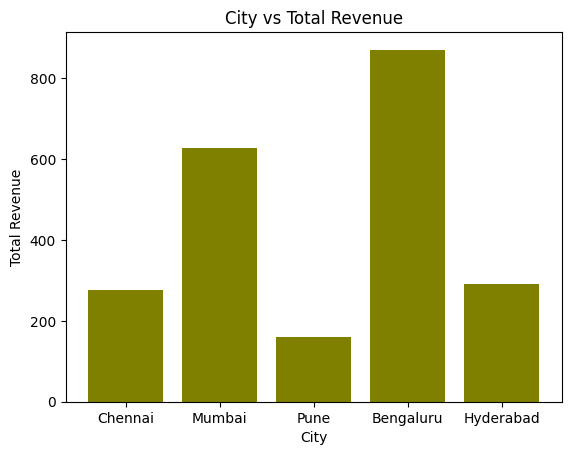

In [56]:
# Convert the gold view results (city revenue) to Pandas and plot a bar chart of city vs total revenue.
import pandas as pd
import matplotlib.pyplot as plt

city_rev = spark.sql("""
SELECT city, SUM(total_amount) AS total_revenue FROM gold_view GROUP BY city
""").toPandas()

plt.bar(city_rev['city'], city_rev['total_revenue'])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['olive'])
plt.title("City vs Total Revenue")
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.show()

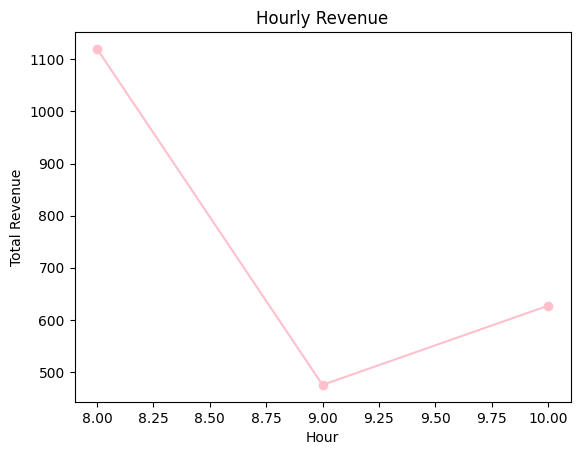

In [42]:
# Plot a line chart of hourly revenue: group by hour(ts) and sum total_amount .
hourly = spark.sql("""
SELECT hour(ts) AS hr, SUM(total_amount) AS total_rev FROM gold_view GROUP BY hr ORDER BY hr
""").toPandas()

plt.plot(hourly['hr'], hourly['total_rev'], marker='o')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['pink'])
plt.title("Hourly Revenue")
plt.xlabel("Hour")
plt.ylabel("Total Revenue")
plt.show()

# 12) Managed vs Unmanaged Cleanup
    DROP TABLE the managed and unmanaged tables; verify:
    Data for managed is removed with the table (when stored in the warehouse).
    Data for unmanaged stays at DRIVERS_PATH after drop.

In [45]:
# Drop if exists
spark.sql("DROP TABLE IF EXISTS trips_managed_real")

# Create a true managed table (data stored in warehouse path)
df_trips.write.format("delta").saveAsTable("trips_managed_real")

print("\nManaged table detail BEFORE drop:")
spark.sql("DESCRIBE DETAIL trips_managed_real").show(truncate=False)

# Get warehouse location from Spark config
warehouse_dir = spark.conf.get("spark.sql.warehouse.dir")
managed_path = f"{warehouse_dir}/trips_managed_real"

# Drop the managed table
spark.sql("DROP TABLE trips_managed_real")

# Check if the data folder still exists
import os
print("Managed table data exists after drop?", os.path.exists(managed_path))

# Now check unmanaged table behavior
spark.sql("DROP TABLE IF EXISTS drivers_ext")
print("Unmanaged drivers data exists after drop?", os.path.exists(DRIVERS_PATH))



Managed table detail BEFORE drop:
+------+------------------------------------+----------------------------------------+-----------+------------------------------------------------+----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                                    |description|location                                        |createdAt             |lastModified           |partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+----------------------------------------+-----------+------------------------------------------------+----------------------+-----------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|d

# 13) Constraint/Quality Check (Optional)
    Add a check to reject rows where tip < 0 (enforce during write or simulate with a filter before save).
    Demonstrate an attempt to write bad data and show how you prevented it.

In [46]:
bad_data = [(1011,"R010","D011","Pune", 5.0, 100.0, -5.0, datetime(2025,8,8,11,0,0))]
df_bad = spark.createDataFrame(bad_data, schema=trip_schema)
df_bad_filtered = df_bad.filter(F.col("tip") >= 0)  # rejects bad data
df_bad_filtered.show()

+-------+--------+---------+----+-----------+----+---+---+
|trip_id|rider_id|driver_id|city|distance_km|fare|tip| ts|
+-------+--------+---------+----+-----------+----+---+---+
+-------+--------+---------+----+-----------+----+---+---+



# 14) Convert Parquet → Delta (Optional)
    Save a small subset of trips as Parquet in a new folder and CONVERT TO DELTA.
    Show it can now accept MERGE and time travel.

In [47]:
PARQUET_PATH = f"{BASE}/parquet_sample"
spark.read.format("delta").load(TRIPS_PATH).limit(3).write.mode("overwrite").parquet(PARQUET_PATH)
spark.sql(f"CONVERT TO DELTA parquet.`{PARQUET_PATH}`")
spark.read.format("delta").load(PARQUET_PATH).show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# 15) Bonus KPI Dashboard (Notebook Display)
    Build a quick section showing:
    

*   Total revenue
*   Trips per city (bar)
*   Top drivers by revenue (bar)
*   Revenue by hour (line)


    (In Databricks, use display() chart UI; in Colab, use matplotlib.)

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# 1) Total Revenue
total_revenue = df_gold.groupBy().sum("total_amount").collect()[0][0]
print(f"Total Revenue: {total_revenue:.2f}")

Total Revenue: 2222.00


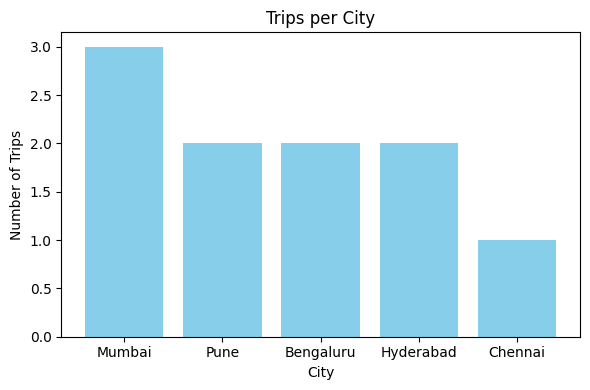

In [49]:
# 2) Trips per city(BAR)
city_trips = (
    df_gold.groupBy("city")
           .count()
           .orderBy(F.desc("count"))
           .toPandas()
)
plt.figure(figsize=(6,4))
plt.bar(city_trips["city"], city_trips["count"], color="skyblue")
plt.title("Trips per City")
plt.xlabel("City")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

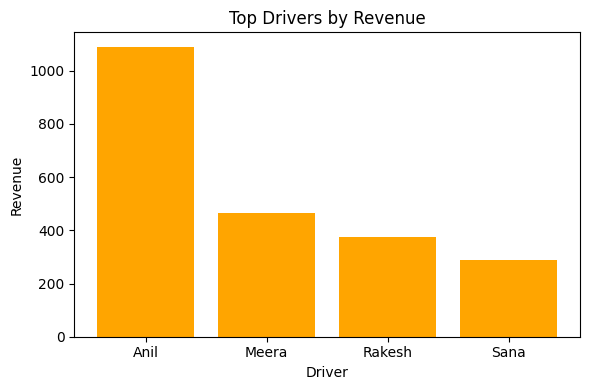

In [54]:
# 3) Top drivers by revenue(BAR)
driver_revenue = (
    df_gold.groupBy("driver_name")
           .sum("total_amount")
           .withColumnRenamed("sum(total_amount)", "revenue")
           .orderBy(F.desc("revenue"))
           .limit(5)
           .toPandas()
)
plt.figure(figsize=(6,4))
plt.bar(driver_revenue["driver_name"], driver_revenue["revenue"], color="orange")
plt.title("Top Drivers by Revenue")
plt.xlabel("Driver")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

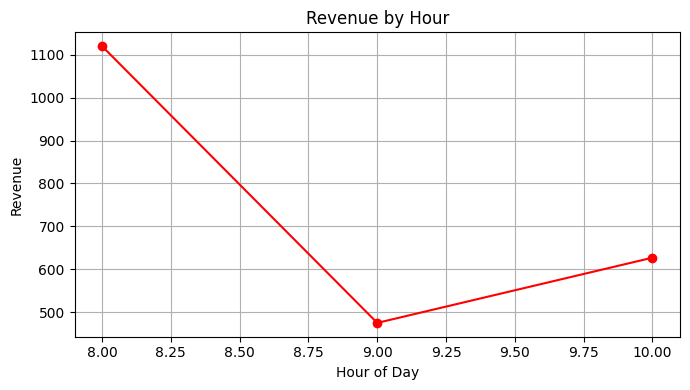

In [53]:
# 4) Revenue by hour(LINE)
hourly_revenue = (
    df_gold.withColumn("hour", F.hour("ts"))
           .groupBy("hour")
           .sum("total_amount")
           .withColumnRenamed("sum(total_amount)", "revenue")
           .orderBy("hour")
           .toPandas()
)
plt.figure(figsize=(7,4))
plt.plot(hourly_revenue["hour"], hourly_revenue["revenue"], marker="o", linestyle="-")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])
plt.title("Revenue by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()